Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [2]:
from sklearn.datasets import load_digits
import numpy as np
import pandas as pd

digits = load_digits()
n_samples = len(digits.images)

X = digits.images.reshape((n_samples, -1))
y = digits.target


In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)


**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

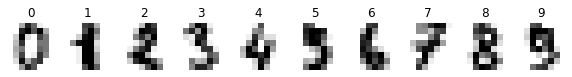

In [4]:
import matplotlib.pyplot as plt

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)
    ax.set_title(label)


## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}|x_{i}-Z_{A(x_{i})}|^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState


In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.

        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.loss = np.finfo(np.float64).max
        self.iter = 0

    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        distance = np.zeros((X.shape[0], self.n_clusters))
        for i, x in enumerate(X):
            distance[i] = [np.linalg.norm(x - c) for c in cluster_centers]
        return distance

    def get_cluster(self, distances_to_centroids):
        return np.array([np.argmin(dist) for dist in distances_to_centroids])

    def get_loss(self, X, nearest_clusters):
        return np.sum((X - self.cluster_centers_[nearest_clusters]) ** 2)

    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))
        for c in range(self.n_clusters):
            mask = nearest_clusters == c
            self.cluster_centers_[c] = np.average(X[mask], axis=0)
        return self.cluster_centers_

    def fit(self, X):
        """Fit the model.

        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
        assert self.n_init > 0

        for _ in range(self.n_init):
            # centriods initialization
            idx = np.random.choice(len(X), self.n_clusters, replace=False)
            current_cluster_centers = X[idx, :]
            loss_iter = np.finfo(np.float64).max
            self.iter = 0


            for iter in range(self.max_iter):

                # calculate distances
                distances_to_centroids = self.calculate_distances_to_centroids(
                    X, current_cluster_centers)
                nearest_clusters = self.get_cluster(distances_to_centroids)

                # update centriods
                current_cluster_centers = self.update_centroids(
                    X, nearest_clusters)
                current_loss = self.get_loss(X, nearest_clusters)

                # check if there is no cluster improvement in current iteration
                if current_loss - loss_iter == 0:
                    break
                elif loss_iter > current_loss:
                    loss_iter = current_loss
            if loss_iter < self.loss:
                self.loss = loss_iter
                self.cluster_centers_ = current_cluster_centers

        return self

    def predict(self, X):
        """Predict classes.

        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            distances_to_centroids = self.calculate_distances_to_centroids(
                X, self.cluster_centers_)
            return self.get_cluster(distances_to_centroids)
        else:
            raise NotFittedError("CustomKMeans instance is not fitted yet")


**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
kmeans = CustomKMeans(n_clusters=10)
kmeans.fit(X)
kmeans.predict(X)

array([3, 0, 0, ..., 0, 6, 4])

In [8]:
custom_kmeans_labels = kmeans.predict(X)
assert custom_kmeans_labels.shape == (1797,)

plot clusters centroids

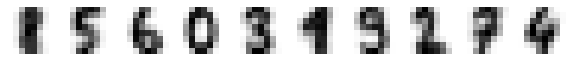

In [9]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 5))
for ax, image in zip(axes.flatten(), kmeans.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)


Now, let's visualize the clusters and centroids in 2D. Firstly, I will apply PCA in order to have an ability to plot the data.

In [10]:
from sklearn.decomposition import PCA

pca = PCA(2) 
X_tranformed = pca.fit_transform(X)

# 10 clusters 
kmeans = CustomKMeans(n_clusters=10)
kmeans = kmeans.fit(X_tranformed)

# predicted values 
cluster_predicted = kmeans.predict(X_tranformed)
labels = np.unique(cluster_predicted)

Finally, the plot with clusters and their centroids.

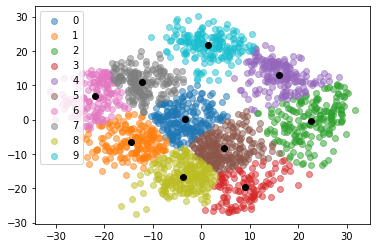

In [11]:
for i in labels:
    plt.scatter(X_tranformed[cluster_predicted == i, 0], X_tranformed[cluster_predicted == i, 1], label=i, alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], color='black')
plt.legend()
plt.show()

From the above plot we can see clearly visible clusters and their centers. PCA allowed us to represent initial 64 features in 2D array. 

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [12]:
# ranges
max_iter_range = np.arange(10, 200, 20)
n_init_range = np.arange(1, 20, 2)

loss_max_iter = []

for max_iter in max_iter_range:
    kmeans = CustomKMeans(n_clusters=10, max_iter=max_iter)
    kmeans.fit(X)

    loss_max_iter.append(kmeans.loss)

In [13]:
# calculation for n_iter

loss_n_init = []

for n_init in n_init_range:
    kmeans = CustomKMeans(n_clusters=10, n_init=n_init)
    kmeans.fit(X)

    loss_n_init.append(kmeans.loss)

Text(0.5, 0, 'n_init')

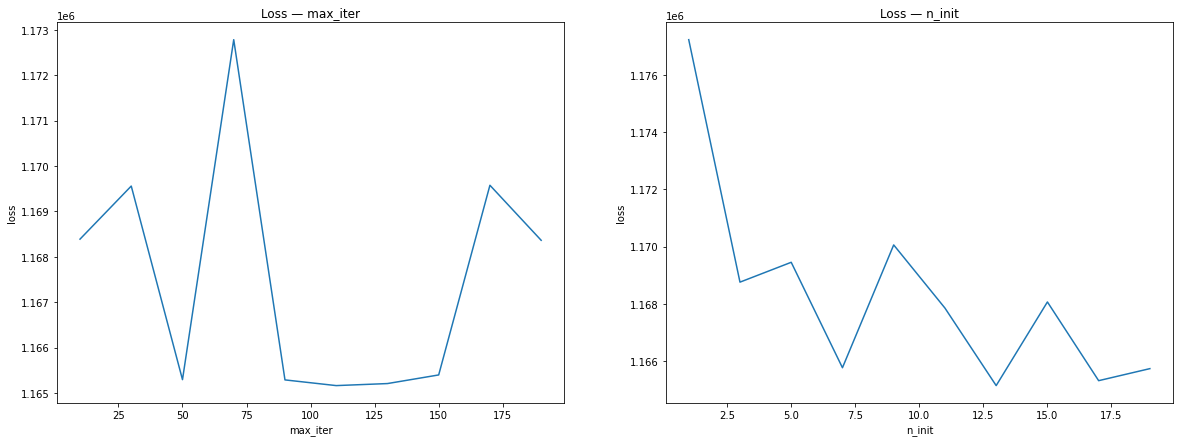

In [14]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(max_iter_range, loss_max_iter)
ax[0].set_title('Loss — max_iter')
ax[0].set_xlabel('max_iter')
ax[0].set_ylabel('loss')

ax[1].plot(n_init_range, loss_n_init)
ax[1].set_title('Loss — n_init')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('n_init')

On the first plot we can observe the dependence of the loss on the maximum number of iterations. As the number of iterations increases, we observe a smooth decrease in the loss and its subsequent stagnation. Thus, it does not always make sense to increase the number of iterations, as this would be a waste of time and resources. At the same time a small number of iterations gives much worse results due to the fact that the algorithm does not have time to converge. Thus, in order to optimize calculations, it is worth not only limiting the number of iterations, but also doing a loss check. If the centroids at the next iteration remain the same, then stop the calculation. 

It is worth paying more attention to n_iter (second plot), because initialization is random and thus there is a high probability that by looking at more variants of initialization we can improve the result. We see several peaks on the graph, and I suspect that this trend will continue as n_iter increases. In any case, a large n_iter wastes a lot of time, so it is worth choosing not too large a range of possible values.

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

I will fit model for transformed data at ones. 

In [15]:
def find_cluster_centres(model, X):
    """
    Returns cluster centres for AgglomerativeClustering
    """
    cluster_centers = []

    for a in set(model.labels_):
        mask = model.labels_ == a
        cluster_centers.append(np.average(X[mask], axis=0))
    return np.array(cluster_centers)

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering

k_means = KMeans(n_clusters=10).fit(X)
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X)

hierarchical_labels = hierarchical_clustering.labels_
kmeans_labels = k_means.labels_

# asserts check
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

hierarchical_cluster_centres = find_cluster_centres(hierarchical_clustering, X)

Plot the K-means centriods

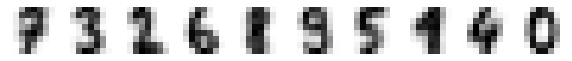

In [17]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 5))
for ax, image in zip(axes.flatten(), k_means.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Plot the Hierarchical clustering centriods

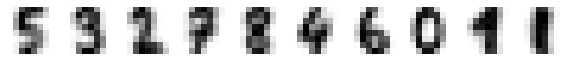

In [18]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 5))
for ax, image in zip(axes.flatten(), hierarchical_cluster_centres):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Fit models (with X_transformed)

In [19]:
k_means = KMeans(n_clusters=10).fit(X_tranformed)
hierarchical_clustering = AgglomerativeClustering(n_clusters=10).fit(X_tranformed)

hierarchical_labels = hierarchical_clustering.labels_
kmeans_labels = k_means.labels_

# asserts check
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

In [20]:
hierarchical_cluster_centres = find_cluster_centres(hierarchical_clustering, X_tranformed)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

In [21]:
def display_cluster(predicted_labels, X, cluster_centers, ax=None):
    labels = np.unique(predicted_labels)
    for i in labels:
        ax.scatter(X[predicted_labels == i, 0], X[predicted_labels == i, 1], label=i, alpha=0.5)
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='black')
    ax.legend()

Text(0.5, 1.0, 'Hierarchical clustering')

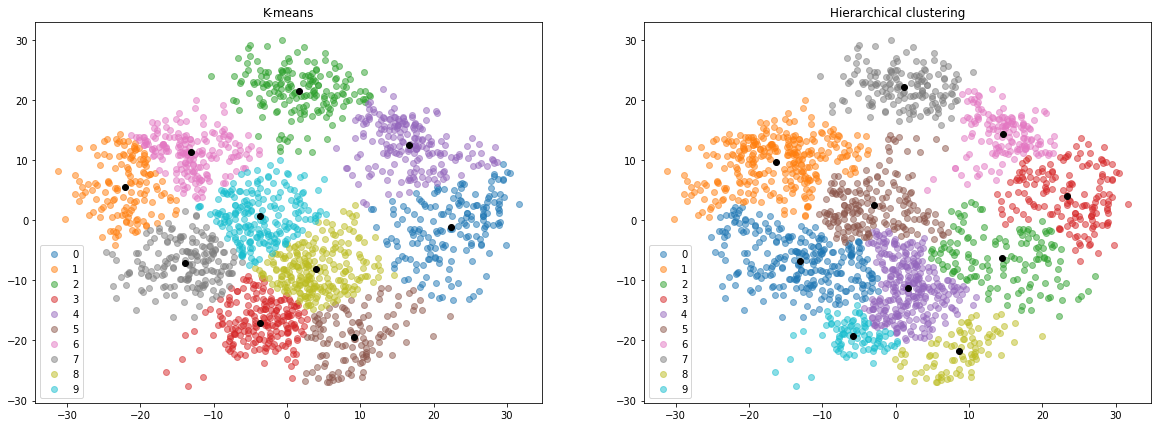

In [22]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))
 
display_cluster(kmeans_labels, X_tranformed, k_means.cluster_centers_, ax[0])
display_cluster(hierarchical_labels, X_tranformed, hierarchical_cluster_centres, ax[1])

ax[0].set_title('K-means')
ax[1].set_title('Hierarchical clustering')

In both plots clusters look pretty good. Here we also can see that the clusters are different for the two models. Their clusters differ not only in shape and size, but also in position.

But still, what does the benchmark look like? Let's have a look at the initial labels. As we are dealing with unsupervised learning, so I don't expect, that prediction will not be even close to the benchmark, because we are dealing with different ML problem.

Text(0.5, 1.0, 'Labeled data')

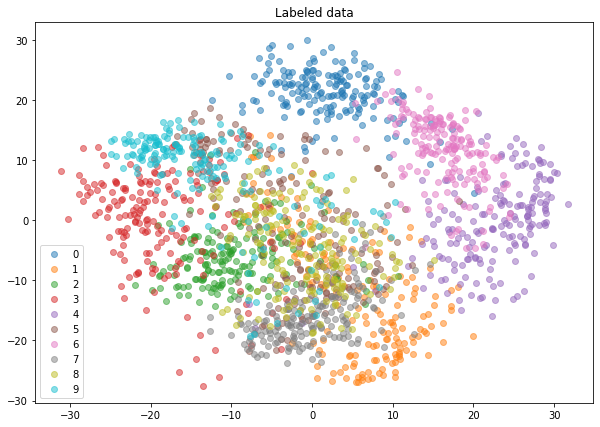

In [23]:
figure_name = plt.figure(figsize=(10, 7))

for i in labels:
    plt.scatter(X_tranformed[y == i, 0], X_tranformed[y == i, 1], label=i, alpha=0.5)
plt.legend()
plt.title('Labeled data')

Interestingly, some clusters (such as 0, 3, 6, 1, 4) are clearly visible, for other classes it is difficult to separate clusters visually. This visualization may help to better understand the data.

### Clustering estimation

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

### Silhouette score

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

**NOTE**: to understand the trend of the score, I took the number of clusters on range (2, 30). In case of (2, 20) it was difficult to understand the behavior of the score.

In [24]:
from sklearn.metrics import silhouette_score, v_measure_score

# number of clusters
clusters = np.arange(2, 31, 1)

kmeans_score = []
hierarchial_clustering_score = []

for c in clusters:
    k_means = KMeans(n_clusters=c).fit(X)
    hierarchical_clustering = AgglomerativeClustering(n_clusters=c).fit(X)
    
    # calculate silhouette_score
    kmeans_score.append(silhouette_score(X, k_means.labels_, metric='euclidean'))
    hierarchial_clustering_score.append(silhouette_score(X, hierarchical_clustering.labels_, metric='euclidean'))

Plots

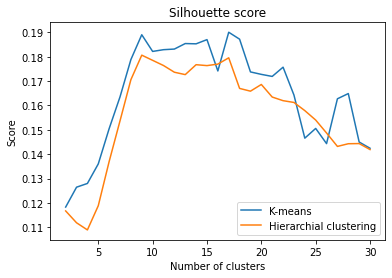

In [25]:
plt.plot(clusters, kmeans_score, label='K-means')
plt.plot(clusters, hierarchial_clustering_score, label='Hierarchial clustering')

plt.title('Silhouette score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()

In general, the score trend for both models changes in a similar way. K-means performs clustering more successfully than hierarchical clustering. 

As we can see in the graph, as the number of clusters (from 2 to 10) increases, then stagnates (from 10 to 15) and then begins to decrease. 

The silhouette in all cases does not exceed 0.19, which in itself is not a sign of good clustering. I assume that this is due to the fact that the data in the clusters are not dense enough. Perhaps by increasing the number of observations we will improve the result.

### $V$-score

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

In [26]:
kmeans_v_score = []
hierarchial_clustering_v_score = []

for c in clusters:
    k_means = KMeans(n_clusters=c).fit(X)
    hierarchical_clustering = AgglomerativeClustering(n_clusters=c).fit(X)
    
    # calculate silhouette_score
    kmeans_v_score.append(v_measure_score(y, k_means.labels_))
    hierarchial_clustering_v_score.append(v_measure_score(y, hierarchical_clustering.labels_))

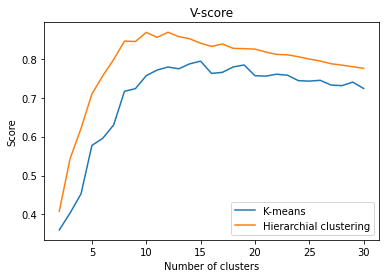

In [27]:
plt.plot(clusters, kmeans_v_score, label='K-means')
plt.plot(clusters, hierarchial_clustering_v_score, label='Hierarchial clustering')

plt.title('V-score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.legend()

In terms of homogeneity and completeness, the hierarchical clustering shows itself well. The score trends for both models are the same: growth (from 2 to 10) and gradual decrease in score.

Score is high in both models. Thus, the predicted values are correct in most cases.

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [28]:
from sklearn.decomposition import TruncatedSVD

# number of components
n_components = [2, 5, 10, 20]

# lists to store score
k_means_silhouette,  k_means_v_score = [], []
hca_silhouette,  hca_v_score = [], []

# models initialization
k_means = KMeans(n_clusters=10)
hca = AgglomerativeClustering(n_clusters=10)

for component in n_components:
    svd = TruncatedSVD(n_components=component, random_state=42)
    X_transformed = svd.fit_transform(X)

    # fit models
    k_means.fit(X_transformed)
    hca.fit(X_transformed)

    k_means_silhouette.append(silhouette_score(X, k_means.labels_, metric='euclidean'))
    hca_silhouette.append(silhouette_score(X, hca.labels_, metric='euclidean'))    

    k_means_v_score.append(v_measure_score(y, k_means.labels_))
    hca_v_score.append(v_measure_score(y, hca.labels_))

In [29]:
silhouette_kmeans_original_data = silhouette_score(X, k_means.fit(X).labels_, metric='euclidean')
silhouette_hca_original_data = silhouette_score(X, hca.fit(X).labels_, metric='euclidean')

v_score_kmeans_original_data = v_measure_score(y, k_means.fit(X).labels_)
v_score_hca_original_data = v_measure_score(y, hca.fit(X).labels_)

Plot score

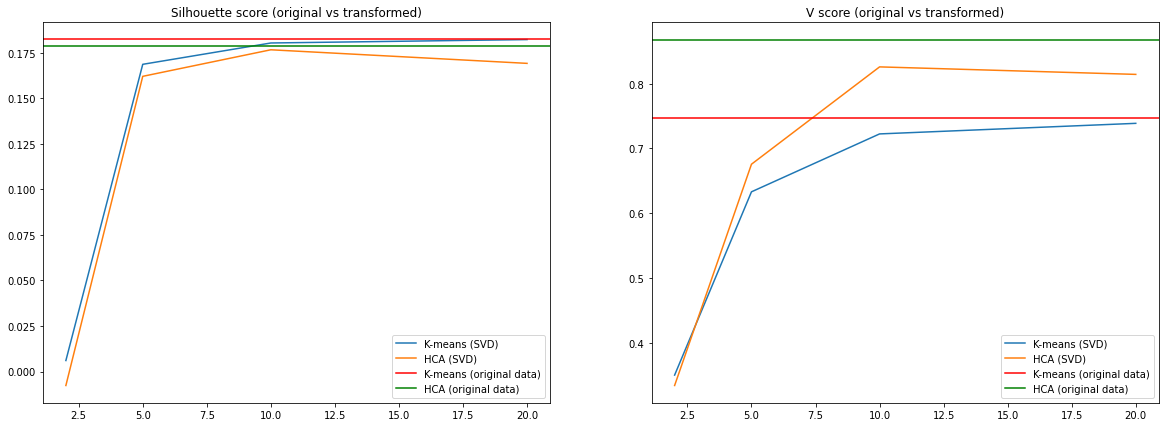

In [30]:
f, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].set_title('Silhouette score (original vs transformed)')

ax[0].plot(n_components, k_means_silhouette, label='K-means (SVD)')
ax[0].plot(n_components, hca_silhouette, label='HCA (SVD)')

ax[0].axhline(y=silhouette_kmeans_original_data, color='r', linestyle='-', label='K-means (original data)')
ax[0].axhline(y=silhouette_hca_original_data, color='g', linestyle='-', label='HCA (original data)')
ax[0].legend()

ax[1].set_title('V score (original vs transformed)')
ax[1].plot(n_components, k_means_v_score, label='K-means (SVD)')
ax[1].plot(n_components, hca_v_score, label='HCA (SVD)')
ax[1].axhline(y=v_score_kmeans_original_data, color='r', linestyle='-', label='K-means (original data)')
ax[1].axhline(y=v_score_hca_original_data, color='g', linestyle='-', label='HCA (original data)')

ax[1].legend()

From the above plots we can see for 2, 5, 10 components the score is increasing. However, compared to the rush calculated for the original data, it is slightly smaller.

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [31]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)
tsne_result.shape

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(1797, 2)

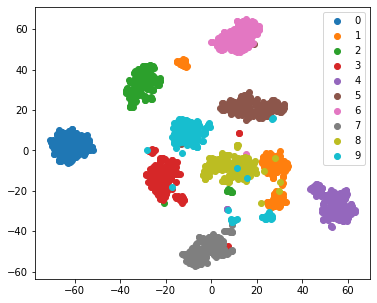

In [32]:
target_ids = range(len(digits.target_names))

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 5))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple']
for i, label in zip(target_ids, digits.target_names):
    plt.scatter(tsne_result[y == i, 0], tsne_result[y == i, 1], label=label)
plt.legend()
plt.show()

We can see on the plot 10 clusters.

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [33]:
hca.fit(tsne_result)
k_means.fit(tsne_result)


print('K-Means')
print(f'Silhouette score: tSNE = {silhouette_score(X, k_means.labels_, metric="euclidean")}, original data = {silhouette_kmeans_original_data}')
print(f'V-score: tSNE = {v_measure_score(y, k_means.labels_)}, original data = {v_score_kmeans_original_data}')
print('_' * 100)

print('HCA')
print(f'Silhouette score: tSNE = {silhouette_score(X, hca.labels_, metric="euclidean")}, original data = {silhouette_hca_original_data}')
print(f'V-score: tSNE = {v_measure_score(y, hca.labels_)}, original data = {v_score_hca_original_data}')

K-Means
Silhouette score: tSNE = 0.1639076020820966, original data = 0.18235444782392538
V-score: tSNE = 0.9170988024556599, original data = 0.7472322034261627
____________________________________________________________________________________________________
HCA
Silhouette score: tSNE = 0.1639015742435977, original data = 0.17849659940596496
V-score: tSNE = 0.9197824190895375, original data = 0.8681701126909083


We can observe, that after applying tSNE we got better V-score. In case of silhoutte original data had a better perfomance for both models.

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

In both cases HCA had better scores. So, for vizualization I've chosen HCA with tSNE transformation.

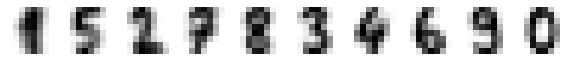

In [34]:
hierarchical_cluster_centres = find_cluster_centres(hca, X)

_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 5))
for ax, image in zip(axes.flatten(), hierarchical_cluster_centres):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

If we compare the centroids before and after applying the dimensionality reduction and subsequent training methods, we can see that the centroids have become clearer and each digit can be identified in this way.

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

Hierarchical clustering has showed better V-score than K-means. K-means at the same time has showed better silhuette score. Personally, for this clutering problem I'd choose K-Means, as we exactly know, how much clusters it should be (10). Also on the untransformed data K-means provided clearer images of cluster centers and not bad metrics values.

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

**(0.5 points)** Does dimensionality reduction improve clustering results?

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [35]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

X.shape

(70000, 784)

In [36]:
X.loc[1]

pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Name: 1, Length: 784, dtype: float64

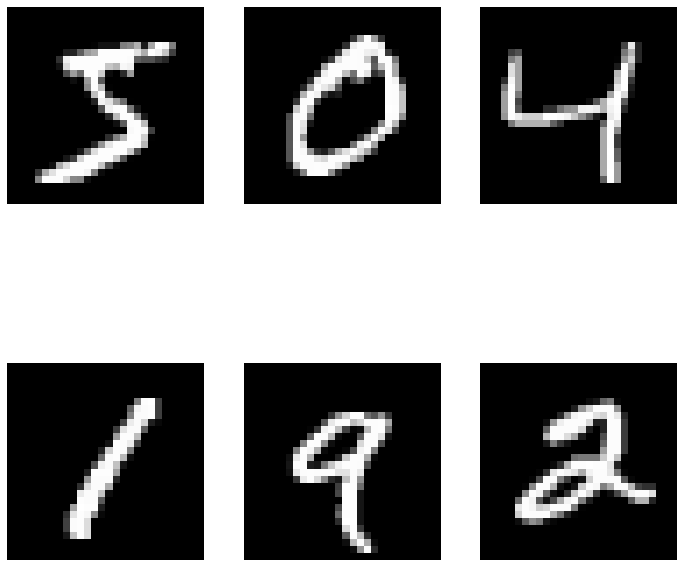

In [37]:
fig, axs = plt.subplots(2, 3, figsize = (12, 12))
plt.gray()

for i, ax in enumerate(axs.flat):
  ax.matshow(X.values[i].reshape(28,28))
  ax.axis('off')

Data preprocessing.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# dataset splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# standartization
scaler = StandardScaler()
scaler.fit(X_train)

X_train_transformed = scaler.transform(X_train)
X_test_transformed = scaler.transform(X_test)

Dimention reduction.

In [39]:
from sklearn.decomposition import PCA

pca = PCA(0.95)
pca.fit(X_train)

print('Number of components', pca.n_components_)

X_train_pca = pca.transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

Number of components 154


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [40]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(X_train_pca)

In [41]:
print('silhouette_score')
print('Train:', silhouette_score(X_train_pca, kmeans.labels_, metric='euclidean'))
print('Test:', silhouette_score(X_test_pca, kmeans.predict(X_test_pca), metric='euclidean'))

silhouette_score
Train: 0.05005703474502614
Test: 0.051314011423930474


In [42]:
print('v_measure_score')
print('Train: ', v_measure_score(y_train, kmeans.labels_))
print('Test', v_measure_score(y_test, kmeans.predict(X_test_pca)))

v_measure_score
Train:  0.42290059101103994
Test 0.4266552119741578
